In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from collections import Counter
from sklearn.metrics import r2_score

In [5]:
# function for percolating 
def percolate(L, p):
    # make L x L grid of numbers (0 - 1): np.random.rand(L, L) < p
    ## occupy elements with probability > p, if probability < p, cell is not occupied
    occupiedGrid = (np.random.rand(L, L) < p)

    # locate clusters 
    labeled, num_clusters = label(occupiedGrid)

    # if no clusters, return 0
    if num_clusters == 0:
        return [], labeled, num_clusters
    
    # get size of each cluster
    labels, counts = np.unique(labeled, return_counts=True)

    cluster_sizes = counts[labels != 0]

    return list(cluster_sizes), labeled, num_clusters

In [6]:
# simulation

L = 100                                     # Lattice side length
num_runs = 500                               # number of runs
p_values = np.linspace(0, 1, 100)            # p values to test

# container for mean largest and non-largest cluster sizes
mean_largest_cluster_sizes = []
mean_other_cluster_sizes = []

# loop over each p
for p in tqdm(p_values):
    # lists to store results for current p across trials
    trials_largest_cluster = []
    trials_mean_of_others = []

    # multiple runs for each p
    for trial in range(num_runs):
        # cluster sizes for single lattice iteration
        all_sizes, _, _= percolate(L, p)

        # run if any cluster exists
        if len(all_sizes) > 0:
            largest_size = max(all_sizes)
            trials_largest_cluster.append(largest_size)

            # get size of other clusters if more than 1 is present
            if len(all_sizes) > 1:
                non_largest_sizes = list(all_sizes)
                non_largest_sizes.remove(largest_size)

                # for the other clusters, get mean size
                trials_mean_of_others.append(np.mean(non_largest_sizes))
    
    # for all runs for current p, get final mean of runs

    ## for largest cluster
    if len(trials_largest_cluster) > 0:
        mean_largest_cluster_sizes.append(np.mean(trials_largest_cluster))
    else:
        mean_largest_cluster_sizes.append(0) # largest cluster doesnt exist
    
    ## for non-largest clusters
    if len(trials_mean_of_others) > 0:
        mean_other_cluster_sizes.append(np.mean(trials_mean_of_others))
    else:
        mean_other_cluster_sizes.append(0)

100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Estimated critical probability (pc): 0.5960


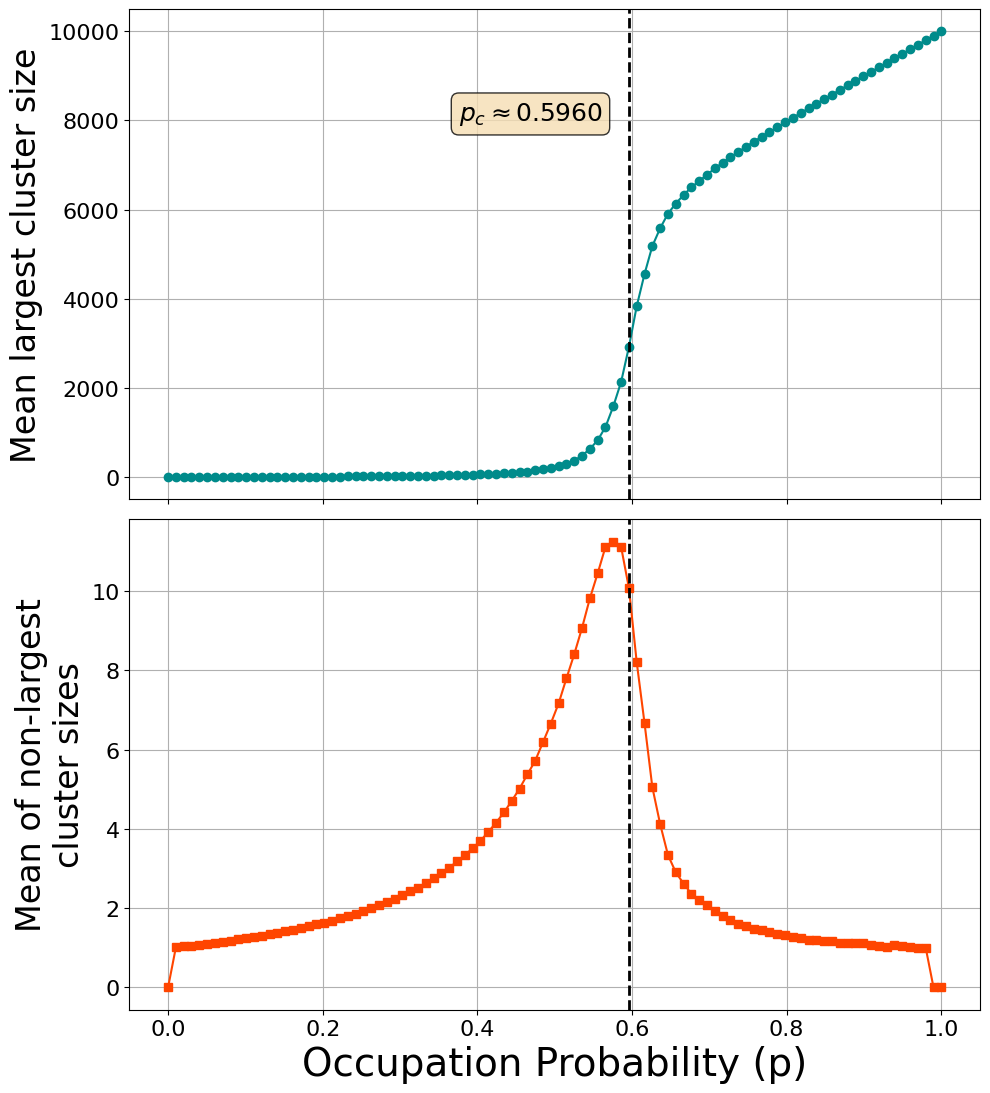

In [39]:
gradient = np.gradient(mean_largest_cluster_sizes, p_values)
pc_est_index = np.argmax(gradient)
pc_est = p_values[pc_est_index]

print(f"Estimated critical probability (pc): {pc_est:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# mean size of largest cluster
ax1.plot(p_values, mean_largest_cluster_sizes, 'o-', color='darkcyan', label='Largest cluster')
ax1.set_ylabel('Mean largest cluster size', fontsize=24)
#ax1.set_title(f'Percolation on a {L}x{L} Lattice (Averaged over {num_runs} trials)')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.grid(True)

# mean size of non-largest clusters
ax2.plot(p_values, mean_other_cluster_sizes, 's-', color='orangered', label='Non-largest clusters')
ax2.set_ylabel('Mean of non-largest\ncluster sizes', fontsize=24)
ax2.set_xlabel('Occupation Probability (p)', fontsize=28)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.grid(True)

for ax in [ax1, ax2]:
    ax.axvline(x=pc_est, color='black', linestyle='--', linewidth=2, label=f'$p_c$ = {pc_est:.4f}')

ax1.annotate(f'$p_c \\approx {pc_est:.4f}$', xy=(pc_est, 3000), xytext=(pc_est - 0.22, 8000), fontsize=18,
    bbox=dict(boxstyle="round,pad=0.3", fc="wheat", ec="black", lw=1, alpha=0.8)
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('means.pdf',dpi=300, bbox_inches='tight')
plt.show()

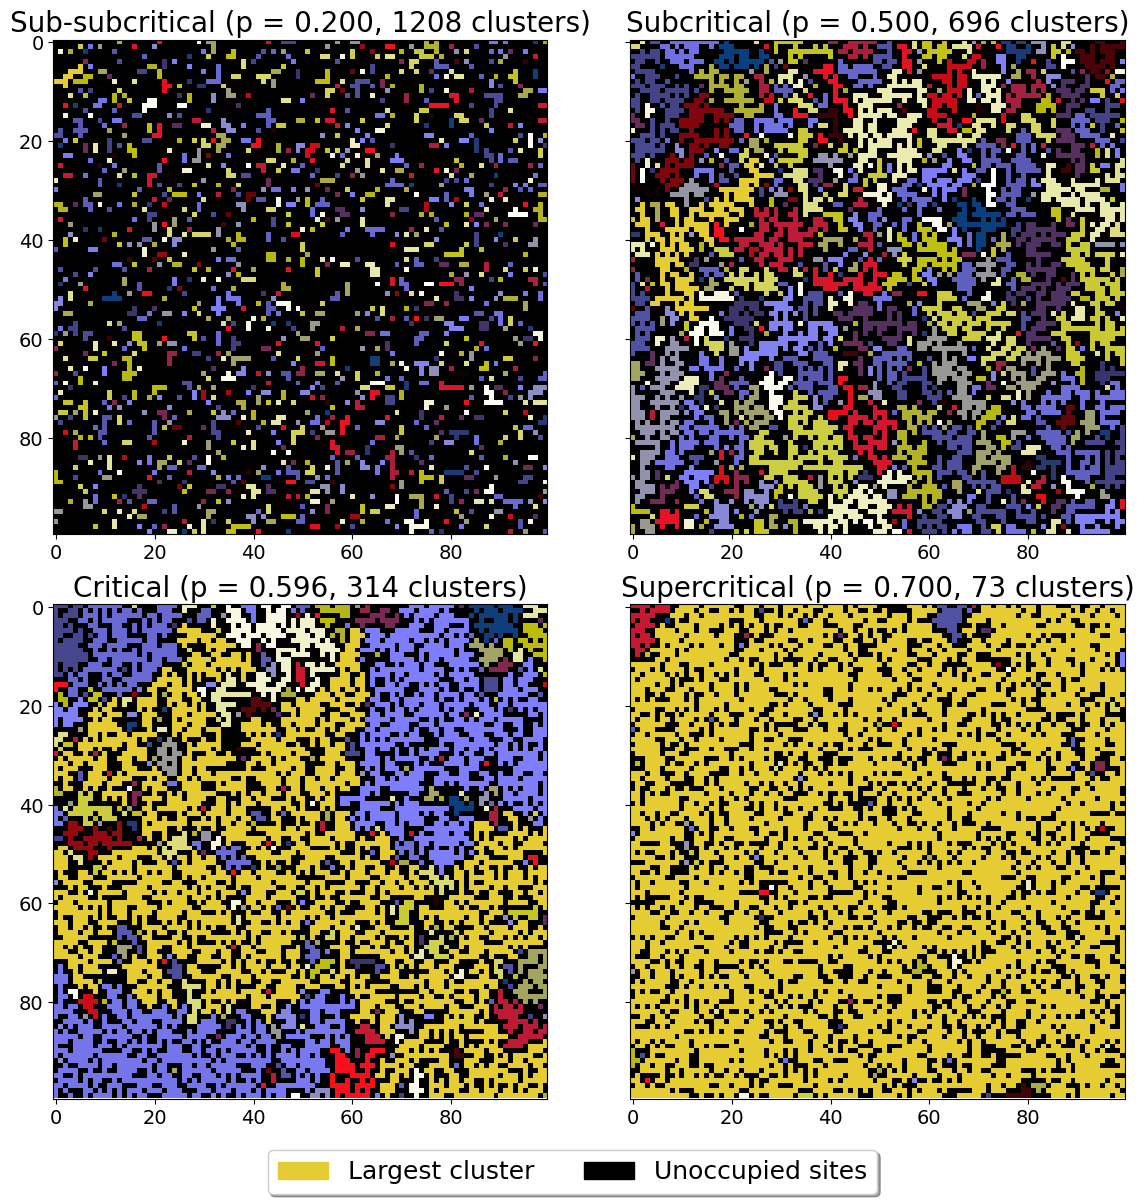

In [22]:
# Plotting individual grid iterations
pValues = [0.2, 0.5, pc_est, 0.7]
titles = ["Sub-subcritical","Subcritical", "Critical", "Supercritical"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

# loop for plotting
for i,p in enumerate(pValues):
    ax = axes.flatten()[i]

    # data for current grid
    clust_size, grid, num_clusters = percolate(L, p)

    if num_clusters == 0:
        ax.imshow(grid, cmap='gray')
        ax.set_title(f'{titles[i]} (p = {p:.3f}, 0 clusters)')
        continue

    largest_cluster_index = np.argmax(clust_size) + 1

    # color map set-up
    gist_stern1 = plt.get_cmap('gist_stern', num_clusters)
    other_colors = list(gist_stern1(np.linspace(0, 1, num_clusters)))
    np.random.shuffle(other_colors)

    colors = [(0, 0, 0, 0)] * (num_clusters + 1)            # temp transparent colors
    colors[0] = (0, 0, 0, 1)                                # unoccupied sites (black)
    colors[largest_cluster_index] = (0.9, 0.8, 0.2, 1)      # color of largest cluster

    color_idx = 0
    for cluster_label in range(1, num_clusters + 1):
        if cluster_label != largest_cluster_index:
            colors[cluster_label] = other_colors[color_idx]
            color_idx += 1
    custom_cmap = ListedColormap(colors)

    fig_save, ax_save = plt.subplots(figsize=(8, 8))
    ax_save.imshow(grid, cmap=custom_cmap, interpolation='nearest')
    #ax_save.set_title(f'{titles[i]} (p = {p:.3f}, {num_clusters} clusters)', fontsize=20)
    ax_save.tick_params(axis='both', which='major', labelsize=16)
    fig_save.savefig(f'{titles[i]}.pdf', dpi=300, bbox_inches='tight')
    plt.close(fig_save)

    ax.imshow(grid, cmap=custom_cmap, interpolation='nearest')
    ax.set_title(f'{titles[i]} (p = {p:.3f}, {num_clusters} clusters)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
legend_patches = [
    mpatches.Patch(color=(0.9, 0.8, 0.2, 1) , label='Largest cluster'),
    mpatches.Patch(color='black', label='Unoccupied sites')
]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.01),
           fancybox=True, shadow=True, ncol=3, fontsize=18)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()

100%|██████████| 10000/10000 [00:03<00:00, 2964.17it/s]


R-squared of the linear fit on log-log data: 0.9765


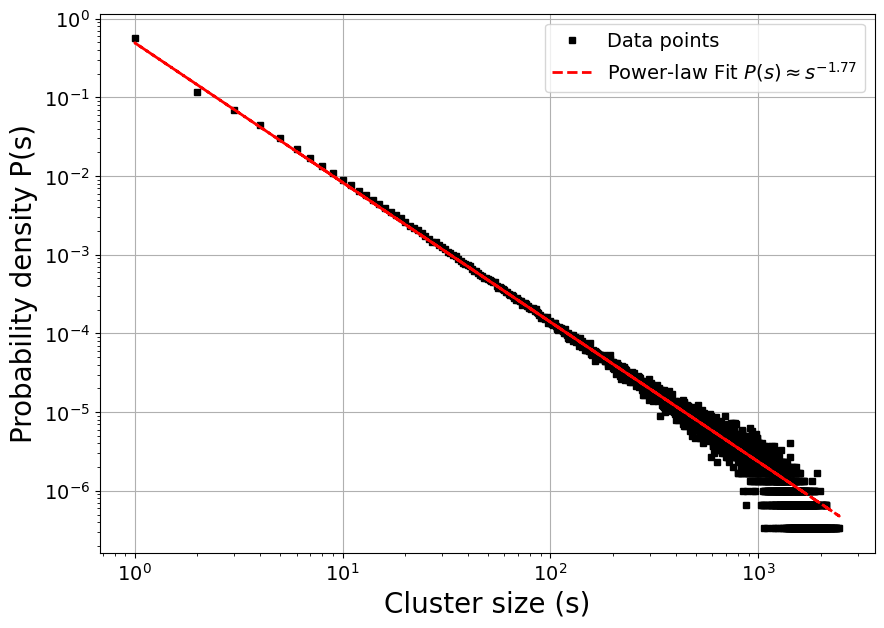

In [ ]:
num_trials = int(10e3)
all_non_largest_sizes = []

for trial in tqdm(range(num_trials)):
    all_sizes,_,_ = percolate(L, pc_est)
    if len(all_sizes) > 1:
        largest_size = max(all_sizes)
        other_sizes = [s for s in all_sizes if s != largest_size]
        all_non_largest_sizes.extend(other_sizes)

# count the occurrences of each size
size_counts = Counter(all_non_largest_sizes)
sizes = np.array(list(size_counts.keys()))
counts = np.array(list(size_counts.values()))

# probability density
probabilities = counts / sum(counts)

# power-law fit
log_sizes = np.log10(sizes)
log_probs = np.log10(probabilities)
## linear range
fit_start_s = 10
fit_end_s = 1000
mask = (sizes >= fit_start_s) & (sizes <= fit_end_s)
## polyfit
coeffs = np.polyfit(log_sizes[mask], log_probs[mask], 1)
slope = coeffs[0]
## generate line given the fit slop
fit_line = coeffs[0] * np.log10(sizes) + coeffs[1]
fit_line_probs = 10**fit_line
predicted_log_probs = coeffs[0] * log_sizes[mask] + coeffs[1]
## goodness of fit
r_squared = r2_score(log_probs[mask], predicted_log_probs)
print(f"R-squared of the linear fit on log-log data: {r_squared:.4f}")


# Plot
plt.figure(figsize=(10, 7))
plt.loglog(sizes, probabilities, 's', markersize=4, label='Data points', color='black')
plt.loglog(sizes, fit_line_probs, '--', color='red', linewidth=2, label=fr'Power-law Fit $P(s) \approx s^{{{slope:.2f}}}$')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Cluster size (s)', fontsize=20)
plt.ylabel('Probability density P(s)', fontsize=20)
#plt.title('Cluster Size Distribution at Criticality (Log-Log Scale)')
plt.grid(True)
plt.legend(fontsize=14)
plt.savefig('loglogPower.pdf',dpi=300,bbox_inches='tight')
plt.show()